# Expectation Maximazation with Gaussian Mixtures

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

plt.rcParams.update({
    'figure.figsize': (20, 10),
    'axes.grid': True,
    'font.size': 15,
})

As with k-means, we first load the data, delete the index column and normalize the data.

In [3]:
data = pd.read_csv('faithful.csv', delim_whitespace=True)
del data['i']
data = (data - data.min()) / (data.max() - data.min())
data.head()

,eruptions,waiting
0,0.571429,0.679245
1,0.057143,0.207547
2,0.495143,0.584906
3,0.195143,0.358491
4,0.838000,0.792453


Now we define the e-step function for the EM algorithm. This implementation uses a spherical covariance estimation. The e-step function additionally returns the internal weighted probability, which can be used to do the predictions later. This way, predictions will cause a little overhead due to the calculation of the actual e-step values.

In [4]:
def e_step(data, weights, means, prec):
    prec2 = prec ** 2
    log_prob = np.sum(means ** 2, 1) * prec2 - 2 * np.dot(data, means.T * prec2) + np.outer(np.einsum('ij,ij->i', data, data), prec2)
    log_det = data.shape[1] * np.log(prec)
    w_prob = -.5 * (data.shape[1] * np.log(2 * np.pi) + log_prob) + log_det + weights
    
    prob = np.log(np.sum(np.exp(w_prob), axis=1))
    resp = w_prob - prob[:, None]
    
    return np.mean(prob), resp, w_prob

Now follows the m-step for the EM algorithm. Keeping the design of the e-step, this also utilizes a spherical coveriance estimation.

In [5]:
def m_step(data, l_resp, r_cov):
    resp = np.exp(l_resp)
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    
    weights = nk / data.shape[0]
    means = np.dot(resp.T, data) / nk[:, None]
    cov = (np.dot(resp.T, data * data) / nk[:, None] - 2 * means * np.dot(resp.T, data) / nk[:, None] + means**2 + r_cov).mean(1)
    prec = 1. / np.sqrt(cov)
    
    return weights, means, cov, prec

The following training method expects the following inputs:
- Data, preferably as pandas `DataFrame` or as simple NumPy array.
- Number of cluster centers
- Regularization value for the coveriance matrix
- Delta value, determining when to assume convergence

The training method does at least 100 steps. If there's no convergence within the first 100 steps, retry. The inital values are generated randomly, resulting in different results on different runs, assuming different seeds.

In [6]:
def gaussianMixtureTrain(data, nCenters, r_cov, eps):
    resp = np.random.rand(data.shape[0], nCenters)
    resp /= resp.sum(axis=1)[:, None]
    
    weights, means, cov, prec = m_step(data, resp, r_cov)
    
    prob = -np.infty
    probs = []
    
    for i in range(100):
        prev_prob = prob
        
        prob, resp, _ = e_step(data, weights, means, prec)
        weights, means, cov, prec = m_step(data, resp, r_cov)
        
        delta = prob - prev_prob
        
        probs.append(prob)
        
        if abs(delta) < eps:
            return (weights, means, cov, prec, probs)
    
    raise ValueError('Did not converge')

The prediction method expects a list of data points, as well as the return values from the training method (except for the covariance matrix). Each entry in the data point list is a single data point. The return value is a list of labels for each given data point.

In [7]:
def gaussianMixturePredict(datapoint, weights, means, prec):
    return e_step(datapoint, weights, means, prec)[2].argmax(axis=1)

The score method expects a list of data points, as well as the return values from the training method (except for the covariance matrix). Each entry in the data point list is a single data point. The return value is a list of weighted log-probabilities for each data point.

In [8]:
def gaussianMixtureScore(datapoint, weights, means, prec):
    return np.log(np.sum(np.exp(e_step(datapoint, weights, means, prec)[2]), axis=1))

Now we train a Gaussian Mixture Model, using the Old Faithful dataset. Due to prior knowledge, we assume a number of cluster centers of 2.

In [9]:
weights, means, cov, prec, probs = gaussianMixtureTrain(data, 2, 1e-06, 0.001)

Print the labels for known regions, where different labels are expected. We can't assume knowledge about the actual label, due to the label switching problem.

In [10]:
print('Label for [{:.1f}, {:.1f}]: {:d}'.format(0.2, 0.2, gaussianMixturePredict(np.array([0.2, 0.2]).reshape(1, -1), weights, means, prec)[0]))
print('Label for [{:.1f}, {:.1f}]: {:d}'.format(0.8, 0.8, gaussianMixturePredict(np.array([0.8, 0.8]).reshape(1, -1), weights, means, prec)[0]))

Label for [0.2, 0.2]: 1
Label for [0.8, 0.8]: 0


For a visualization, we now draw a contour plot as well as a scatter plot for the given dataset with the computed Gaussian Mixture classification. The labels are encoded in the data point color.

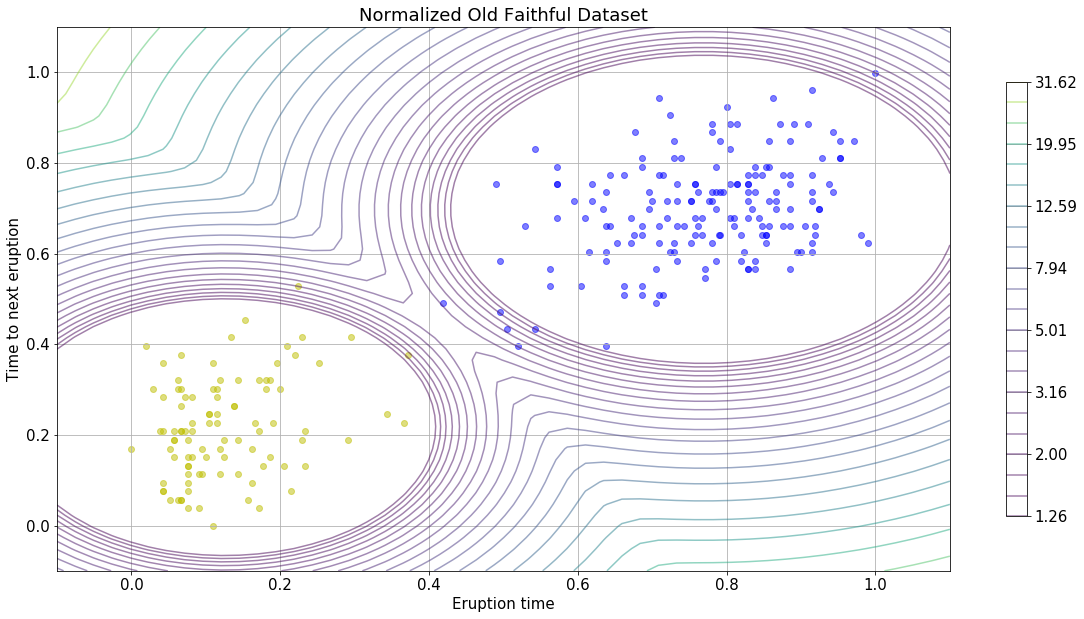

In [11]:
x = np.linspace(-0.1, 1.1)
y = np.linspace(-0.1, 1.1)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -1 * gaussianMixtureScore(XX, weights, means, prec)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, levels=np.logspace(0.1, 1.7, 25), alpha=0.5)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
labels = gaussianMixturePredict(data, weights, means, prec)
plt.scatter(data.iloc[(labels == 0), 0], data.iloc[(labels == 0), 1], marker='o', c='b', alpha=0.5)
plt.scatter(data.iloc[(labels == 1), 0], data.iloc[(labels == 1), 1], marker='o', c='y', alpha=0.5)

plt.xlabel('Eruption time')
plt.ylabel('Time to next eruption')
plt.title('Normalized Old Faithful Dataset')
plt.axis('tight')
plt.show()

Additionally, we now plot the expected data log likelihood during each iteration step.

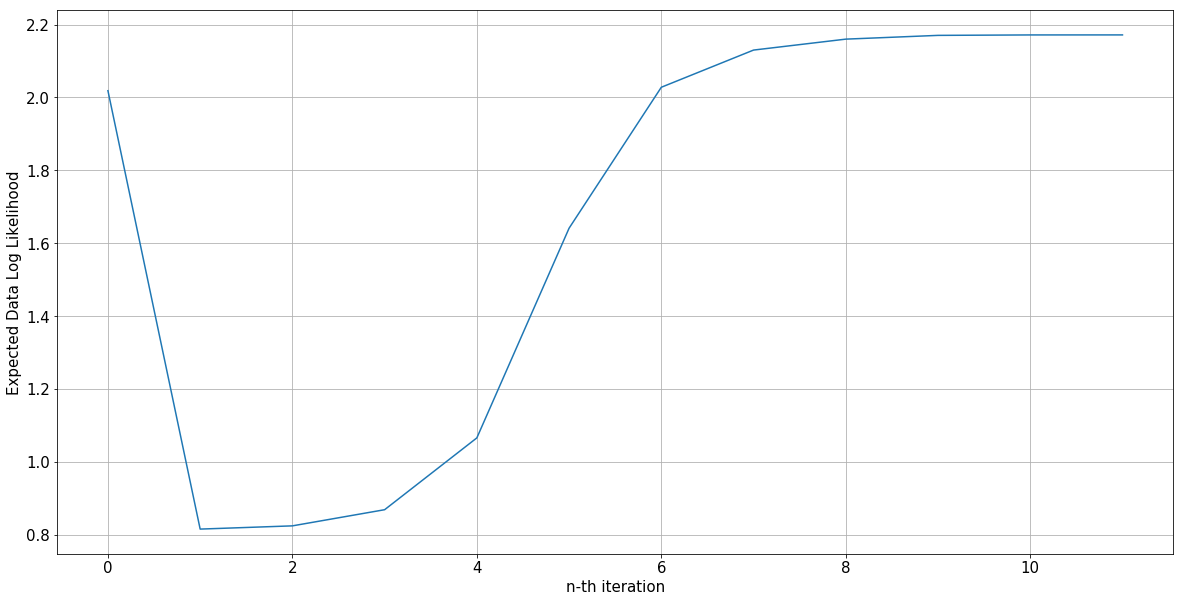

In [12]:
plt.figure(1)
plt.plot(np.arange(len(probs)) + 1, probs)
plt.xlabel('n-th iteration')
plt.ylabel('Expected Data Log Likelihood')
plt.show()

We now do the same, but for each k in the range of [2, 10].

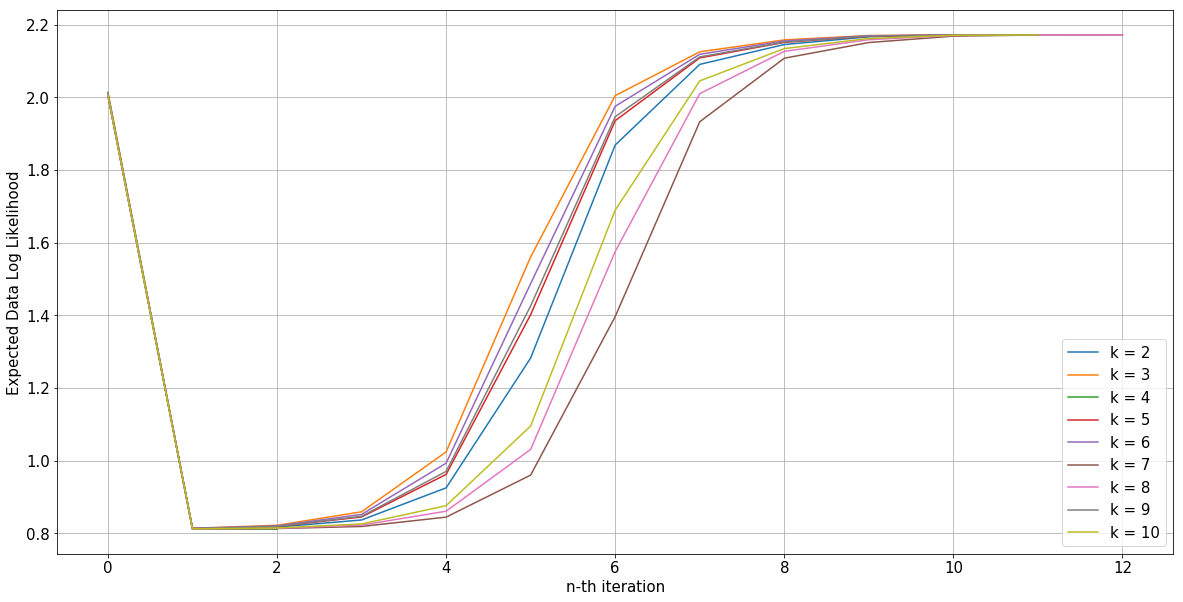

In [13]:
plt.figure(1)

for k in range(2, 11):
    _, _, _, _, probs = gaussianMixtureTrain(data, 2, 1e-06, 0.001)
    plt.plot(np.arange(len(probs)) + 1, probs, label='k = {:d}'.format(k))

plt.legend()
plt.xlabel('n-th iteration')
plt.ylabel('Expected Data Log Likelihood')
plt.show()

As you can see, for some runs, the curves could describe a convergence zone around 2, but this would be misleading. The curves tend to converge against a maximum at around 8 iterations. This applies for all k in the tested range.